In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import zipfile
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
import fiona
import shapely.wkt
import shapefile as shp
import plotly.express as px
from datetime import datetime
import calendar
from matplotlib_venn import venn2
import pandas as pd
from prophet import Prophet
import calendar


import plotly.express as px
from statsmodels.tsa.stattools import acf
from scipy.signal import periodogram
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from __future__ import division
import chart_studio
import chart_studio.plotly as py

chart_studio.tools.set_credentials_file(username='atmikapai',
                                        api_key='wrsg5olPZD0Qi0MxdC0Y')

In [6]:
bart_location = pd.read_csv('BART_Station_location.csv')
bart_location['Station'] = bart_location['Abbreviation']

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="http")

def city_state_country(row):
    coord = f"{row['Lat']}, {row['Long']}"
    location = geolocator.reverse(coord, exactly_one=True)
    address = location.raw['address']
    county = address.get('county', '')
    zipcode = address.get('postcode', '')
    row['county'] = county.replace('County', '')
    row['zipcode'] = zipcode
    return row

bart_location = bart_location.apply(city_state_country, axis=1)
bart_location['county'] = np.where(bart_location['City'] == 'San Francisco', 'San Francisco', bart_location['county'])

#Pulling station names and creating station dictinary to toggle between station names and their abbreviations
station_name = bart_location[['Abbreviation', 'Name']].set_index('Abbreviation')
station_names = station_name.to_dict()['Name']
station_abbrv = {v : k for k, v in station_names.items()}

#Plotting bay area counties 
bart_future_stations = gpd.GeoDataFrame(bart_location, geometry=gpd.points_from_xy(bart_location.Long, bart_location.Lat), crs="EPSG:4326") 
bart_location = bart_future_stations.loc[bart_future_stations['Year Built'] != 2030]

In [32]:
#Importing ridership data
exits = pd.read_excel(pd.ExcelFile("Ridership/Daily_Station_Exits v2.xlsx"), sheet_name='Data').fillna(0)
exits = exits[exits['Date']<='2023-09-30']
exits['Count'] = 1
exits['Day'] = exits['Weekend vs Weekday']
exits = exits.drop(columns=['Unnamed: 57', 'FY', 'Weekend vs Weekday'])
exits['Month'] = pd.to_datetime(exits.Date , format='%B').dt.month.astype(int)
exits['Day'] = exits['Day'].str.lower()

In [33]:
#Cleaning ridership data and aggregating monthly ridership
def avg_exits(df):
    df['avg_exits'] = np.divide(df.Exits, df.Count)
    return df

monthly_exits_by_station = exits.drop(columns={'Total'}).groupby(['Year', 'Month','Day'], as_index=False).sum(numeric_only = True)
monthly_exits_by_station = monthly_exits_by_station.melt(id_vars=['Year',
                                        'Month', 
                                        'Day', 'Count']).rename(columns={'variable':'Station', 
                                                                               'value': 'Exits'})
monthly_exits_by_station['Date'] = pd.to_datetime(dict(year=monthly_exits_by_station.Year, month=monthly_exits_by_station.Month, day=1))
monthly_exits_by_station['Station'] = monthly_exits_by_station['Station'].astype(str)

monthly_exits = monthly_exits_by_station.groupby(['Year', 'Month', 'Day', 'Count']).sum(numeric_only = True).reset_index()
monthly_exits['Date'] = pd.to_datetime(dict(year=monthly_exits.Year, month=monthly_exits.Month, day=1))
monthly_exits = avg_exits(monthly_exits)

# Decomposition of Average Weekday Ridership into Trend and Seasonal Components

In [34]:
monthly_weekday_exits = monthly_exits[monthly_exits['Day']=='weekday']
decomposition_post = STL(monthly_weekday_exits['avg_exits'], period=13) 

# Perform the decomposition and extract components
result_post = decomposition_post.fit()
post_trend = pd.DataFrame(result_post.trend)
post_seasonal = pd.DataFrame(result_post.seasonal)

for i in [post_trend, post_seasonal]:
    i['Date'] = monthly_weekday_exits['Date']
    i.reset_index(inplace=True, drop=True)

In [36]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x=monthly_weekday_exits.Date, y=monthly_weekday_exits.avg_exits, name='Average Weekday Exits'),
    row=1, col=1)

fig.add_trace(go.Scatter(x=post_trend.Date, y=post_trend.trend, name='Trend Component'),
    row=2, col=1)

fig.add_trace(go.Scatter(x=post_seasonal.Date, y=post_seasonal.season, name='Season Component'),
    row=3, col=1)

fig.update_layout(height=600, width=800, title_text="Trend Component of Avg Weekday Ridership (1998-2023)")
fig.show()

#py.plot(fig, filename="Trend Component of Avg Weekday Ridership (1998-2023)", auto_open = True);

In [37]:
entries_post2020 = monthly_exits[(monthly_exits['Date']>="2020-04-01") & (monthly_exits['Day']=="weekday")]
decomposition_post = STL(entries_post2020['avg_exits'], period=13) 

# Perform the decomposition
result_post = decomposition_post.fit()
post_trend = pd.DataFrame(result_post.trend)
post_seasonal = pd.DataFrame(result_post.seasonal)

for i in [post_trend, post_seasonal]:
    i['Date'] = entries_post2020['Date']
    i.reset_index(inplace=True, drop=True)

In [38]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x=entries_post2020.Date, y=entries_post2020.avg_exits, name='Average Weekday Exits'),
    row=1, col=1
)

fig.add_trace(go.Scatter(x=post_trend.Date, y=post_trend.trend, name='Trend Component'),
    row=2, col=1
)

fig.add_trace(go.Scatter(x=post_seasonal.Date, y=post_seasonal.season, name='Season Component'),
    row=3, col=1
)

fig.update_layout(height=600, width=800, title_text="Post-Pandemic Average Weekday Ridership Decomposed")
fig.show()

#py.plot(fig, filename="Trend Component of Avg Weekday Ridership (Post-Pandemic)", auto_open = True);

In [39]:
fig = px.line(post_trend, x=post_trend.Date, y=post_trend.trend)
fig.update_layout(height=600, width=1000, title_text="Post-Pandemic Average Weekday Ridership (Trend Component)")
fig.show()
#py.plot(fig, filename="Trend Component of Avg Weekday Ridership (Post-Pandemic)", auto_open = True);

In [40]:
trend_slope = (post_trend['trend'][len(post_trend)-1] - post_trend['trend'][0])/(len(post_trend)-1)

projection = pd.DataFrame()
projection['num'] = np.arange(len(post_trend))
projection['Date'] = post_trend['Date']
projection['trend'] = trend_slope*projection['num'] + post_trend['trend'][0]
projection = projection.drop('num', axis=1)

post_trend['Label'] = "Post-pandemic Trend"
projection['Label'] = "Projected Linear trend"

post_plot = post_trend.copy()
post_plot = post_plot.append(projection).reset_index(drop=True)
post_plot = post_plot.rename(columns={"trend":"Monthly Entries"})

fig = px.line(post_plot, x = "Date", y = "Monthly Entries", color = "Label")

fig.update_layout(
    title={
        'text': "Testing Linearity of Avg Weekday Ridership",
        'y':0.95,
        'x':0.42,
        'xanchor': 'center',
        'yanchor': 'top'})

#slopes
trend_slope1 = (post_trend['trend'][15] - post_trend['trend'][0])/(15-0)
trend_slope2 = (post_trend['trend'][28] - post_trend['trend'][16])/(28-16)
trend_slope3 = (post_trend['trend'][41] - post_trend['trend'][29])/(41-29)

#fig.add_hline(y='2022-07-01')
fig.add_vrect(x0='2020-04-01', x1='2021-06-01', fillcolor="orange", opacity=0.0, annotation_text="Trend slope: " + str(round(trend_slope1,0)), annotation_position="top left")
fig.add_vrect(x0='2021-06-01', x1='2022-08-01', fillcolor="orange", opacity=0.2, annotation_text="Trend slope: " + str(round(trend_slope2,0)), annotation_position="top left")
fig.add_vrect(x0='2022-08-01', x1='2023-09-01', fillcolor="green", opacity=0.2, annotation_text="Trend slope: " + str(round(trend_slope3,0)), annotation_position="top left")

fig.show();

#py.plot(fig, filename="Testing Linearity of Avg Weekday Ridership", auto_open = True);

/var/folders/45/0sm9f9614w77624c01lr1fx40000gn/T/ipykernel_81522/4017063577.py:13: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



## Testing Stationarity

/var/folders/45/0sm9f9614w77624c01lr1fx40000gn/T/ipykernel_81522/3169582886.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/45/0sm9f9614w77624c01lr1fx40000gn/T/ipykernel_81522/3169582886.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



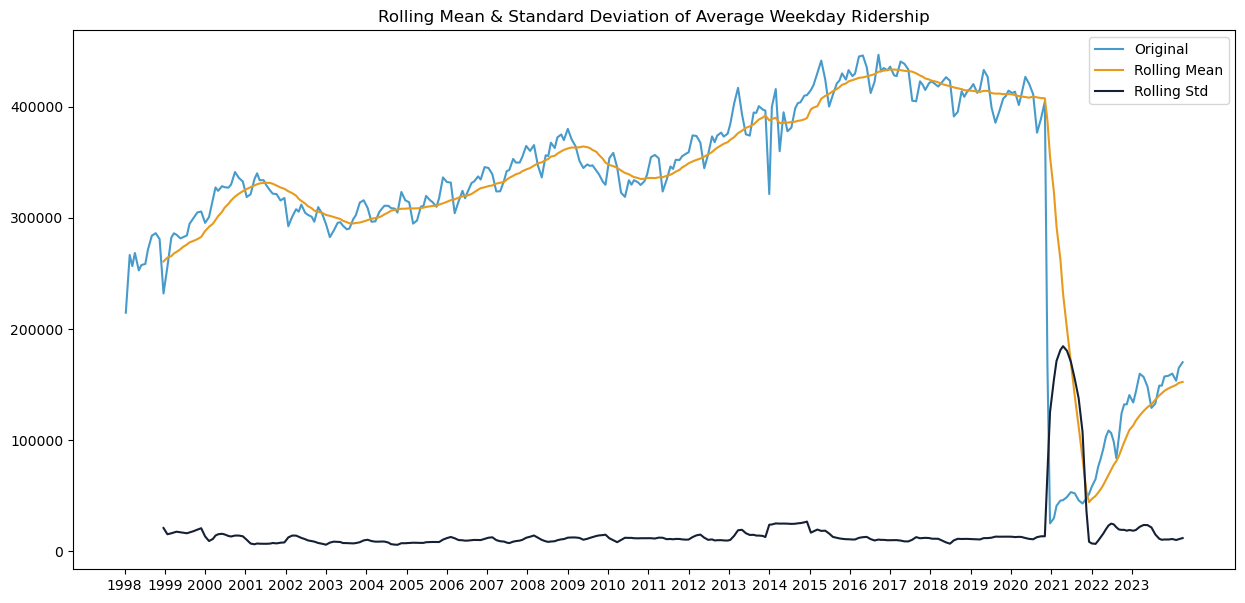

In [41]:
#Determine rolling statistics
monthly_weekday_exits["rolling_avg"] = monthly_weekday_exits['avg_exits'].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
monthly_weekday_exits["rolling_std"] = monthly_weekday_exits['avg_exits'].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(monthly_weekday_exits['avg_exits'], color='#479BCB', label='Original')
plt.plot(monthly_weekday_exits["rolling_avg"], color='#E89A1D', label='Rolling Mean')
plt.plot(monthly_weekday_exits["rolling_std"], color='#152034', label='Rolling Std')
plt.xticks(np.arange(0, 800, 31), monthly_weekday_exits['Year'].unique())
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation of Average Weekday Ridership');
plt.show(block=False);

In [42]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(monthly_weekday_exits['avg_exits'])
print("For BART weekday ridership data, the value of the test statistic is greater than the critical value at all confidence intervals.")
print("Hence we fail to reject the null, and the time series is not stationary.")

Results of Dickey-Fuller Test:
Test Statistic                  -1.802079
p-value                          0.379430
#Lags Used                       5.000000
Number of Observations Used    303.000000
Critical Value (1%)             -3.452118
Critical Value (5%)             -2.871127
Critical Value (10%)            -2.571878
dtype: float64
For BART weekday ridership data, the value of the test statistic is greater than the critical value at all confidence intervals.
Hence we fail to reject the null, and the time series is not stationary.


In [43]:
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print(kpss_output)

print(kpss_test(monthly_weekday_exits['avg_exits']))
print("For BART weekday ridership data, the value of the test statistic is greater than the critical value at all confidence intervals, and hence the series is not stationary.")

Results of KPSS Test:
Test Statistic            0.428853
p-value                   0.064719
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
None
For BART weekday ridership data, the value of the test statistic is greater than the critical value at all confidence intervals, and hence the series is not stationary.


# Differencing, ACF and PACF of Time Series

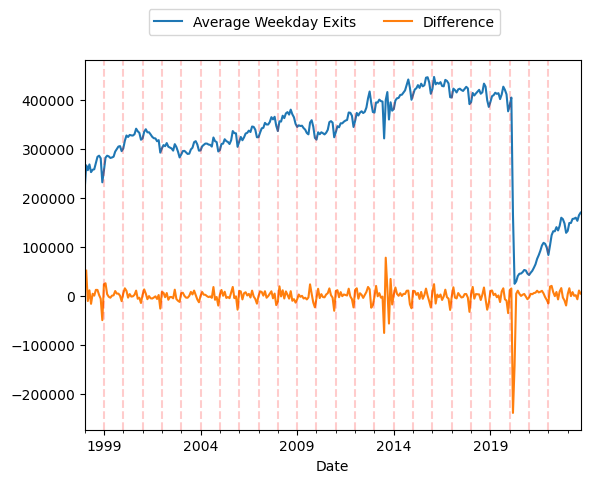

In [45]:
monthly_weekday_exits2 = monthly_weekday_exits[['Date', 'avg_exits']].set_index('Date').rename(columns={'avg_exits': 'Average Weekday Exits'})
monthly_weekday_exits2["Difference"] = monthly_weekday_exits2['Average Weekday Exits'].diff()
ax = monthly_weekday_exits2.plot()
ax.legend(ncol=5, 
          loc='upper center',
          bbox_to_anchor=(0.5, 1.0),
          bbox_transform=plt.gcf().transFigure)
for yr in range(1999, 2023):
    ax.axvline(pd.to_datetime(str(yr)+"-01-01"), color ="red", linestyle = "--", alpha = 0.2)

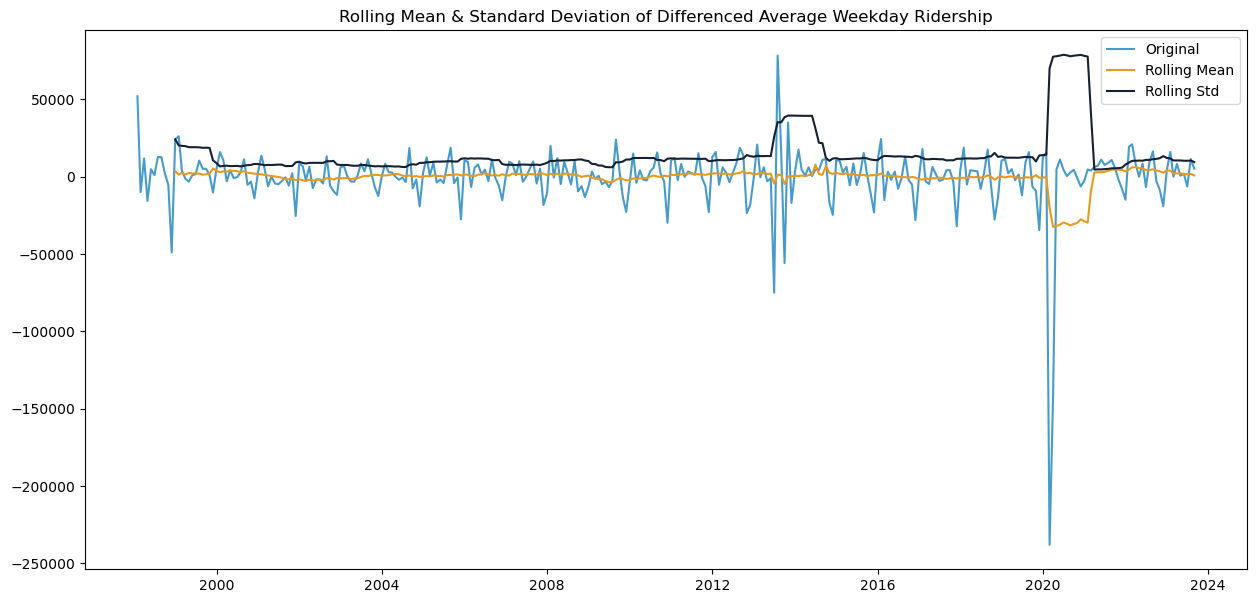

In [47]:
#Determine rolling statistics
monthly_weekday_exits2["rolling_avg"] = monthly_weekday_exits2["Difference"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
monthly_weekday_exits2["rolling_std"] = monthly_weekday_exits2["Difference"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(monthly_weekday_exits2["Difference"], color='#479BCB', label='Original')
plt.plot(monthly_weekday_exits2["rolling_avg"], color='#E89A1D', label='Rolling Mean')
plt.plot(monthly_weekday_exits2["rolling_std"], color='#152034', label='Rolling Std')
#plt.xticks(np.arange(0, 800, 31), monthly_weekday_exits['Year'].unique())
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation of Differenced Average Weekday Ridership')
plt.show(block=False)

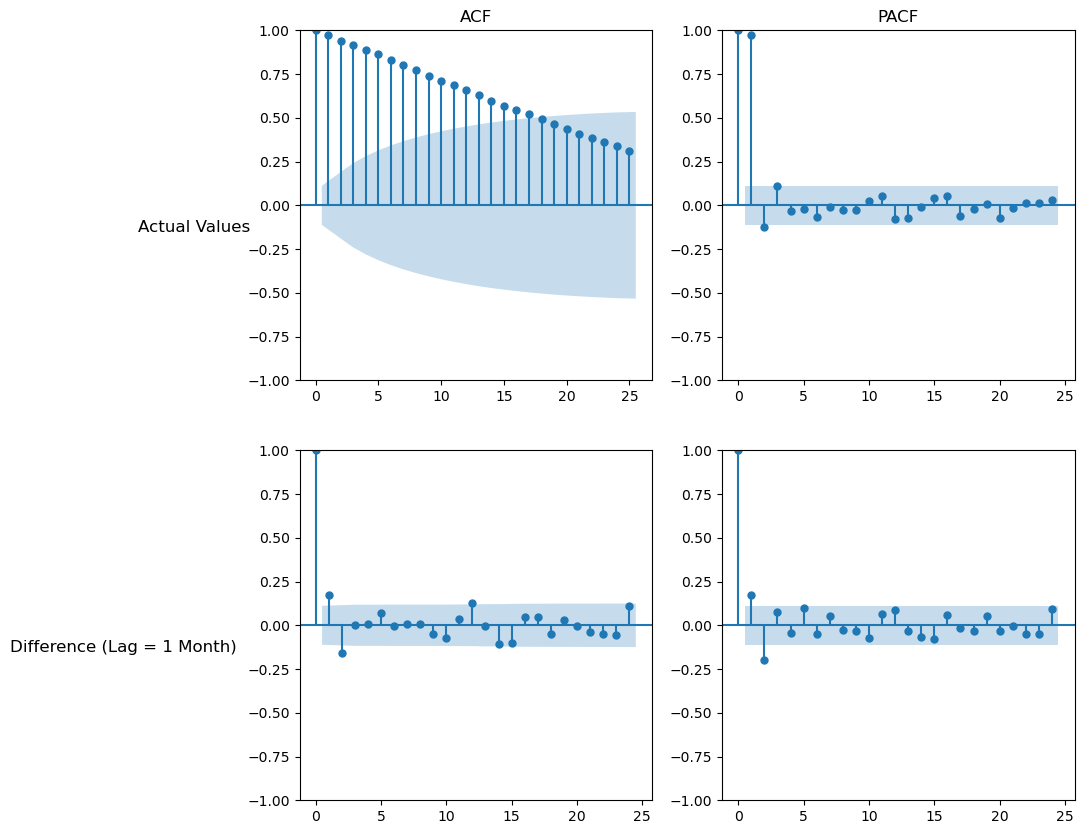

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

monthly_weekday_exits2["Difference"].iloc[0] = 0

plot_acf(monthly_weekday_exits2['Average Weekday Exits'], ax=axes[0, 0]); axes[0, 0].set_title('ACF')
plot_pacf(monthly_weekday_exits2['Average Weekday Exits'], lags=24, method='ywm', ax=axes[0, 1]); axes[0, 1].set_title('PACF')

plot_acf(monthly_weekday_exits2['Difference'], lags=24, ax=axes[1, 0]); axes[1, 0].set_title('Difference (Lag = 1 Month)', y=0.4, x=-0.5)
plot_pacf(monthly_weekday_exits2['Difference'], lags=24, method='ywm', ax=axes[1, 1]); axes[1, 1].set_title('Actual Values', y=1.6, x=-1.5);


# Train and Test Set

## ARIMA

In [49]:
#Seasonal Decompose Plots
from statsmodels.tsa.seasonal import seasonal_decompose 
monthly_weekday_exits = monthly_exits[monthly_exits['Day']=='weekday']
data = monthly_weekday_exits[['Date', 'avg_exits']].set_index('Date')

In [50]:
import pmdarima as pm
train_data = data[(data.index >= '2015-01-01') & (data.index < '2019-01-01')]
test_data = data[(data.index >= '2019-01-01') & (data.index < '2020-01-01')]

SARIMA_model = pm.auto_arima(train_data['avg_exits'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=2, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

In [52]:
y_pred_sarima, confint = SARIMA_model.predict(n_periods=len(test_data), return_conf_int=True)
index_of_fc = test_data.index

# make series for plotting purpose
y_pred_sarima = pd.Series(y_pred_sarima, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)


## Prophet

In [53]:
train_data2 = train_data.reset_index()
train_data2 = train_data2.rename(columns={"Date": "ds", "avg_exits": "y"})

m = Prophet() #seasonality_mode='multiplicative'

m.fit(train_data2)

future = m.make_future_dataframe(periods=12, freq='MS') # freq='M'
future.tail()

prophet_train_forecast = m.predict(future)
prophet_train_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

forecast2 = prophet_train_forecast[['ds', 'yhat']].rename(columns={'ds':'Date'})
forecast2['data'] = 'forecast'
test_data2 = test_data.reset_index().rename(columns={"avg_exits":"yhat"})
test_data2['data'] = 'actuals'
actuals_vs_prd = forecast2.append(test_data2)

17:04:59 - cmdstanpy - INFO - Chain [1] start processing
17:04:59 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/45/0sm9f9614w77624c01lr1fx40000gn/T/ipykernel_81522/3700243149.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



## Performance of Prophet and SARIMA on Test Set

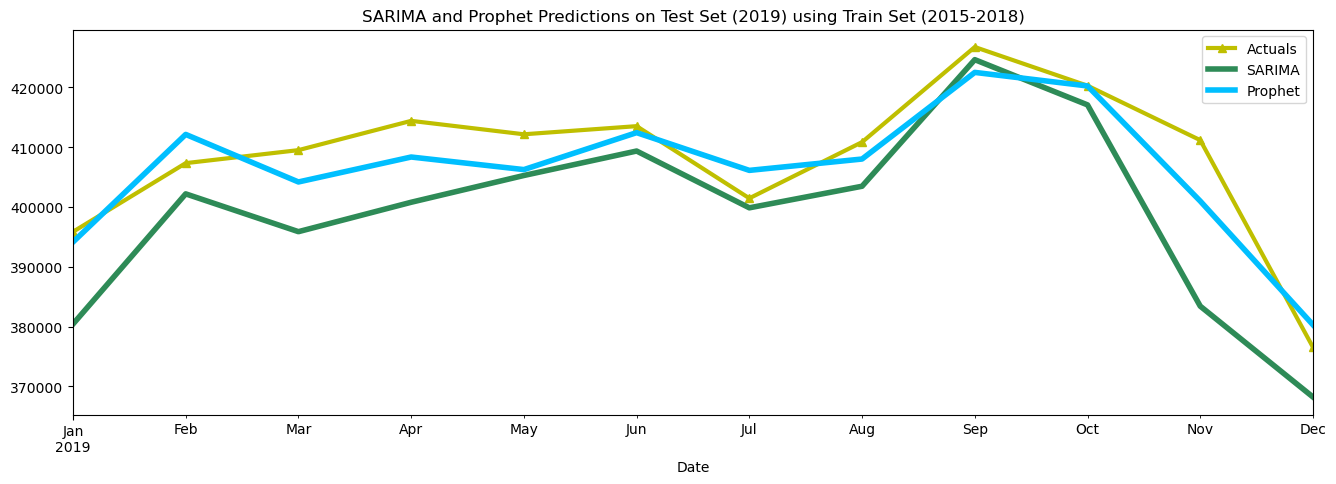

In [55]:
test_data['avg_exits'].name = 'Actuals'
test_data['avg_exits'].plot(figsize = (16,5), legend=True,  lw=3, style='y^-')

prophet_data = forecast2[forecast2['Date'] >= '2019-01-01'].set_index('Date').rename(columns={'yhat': 'avg_exits'})['avg_exits']
prophet_data.name = 'Prophet'

y_pred_sarima.name = 'SARIMA'
y_pred_sarima.plot(legend = True, color='seagreen', lw=4);
prophet_data.plot(legend = True, color='deepskyblue', lw=4)
#forecast2[forecast2['Date'] >= '2019-01-01']['yhat'].plot(legend=True)
plt.title('SARIMA and Prophet Predictions on Test Set (2019) using Train Set (2015-2018)');

In [58]:
forecast2 = prophet_train_forecast[['ds', 'yhat']].rename(columns={'ds':'Date'})
forecast2['data'] = 'forecast'
test_data2 = test_data.reset_index().rename(columns={"avg_exits":"yhat"})
test_data2['data'] = 'actuals'
actuals_vs_prd = forecast2.append(test_data2)

y_true = actuals_vs_prd[(actuals_vs_prd['Date'] >='2019-01-01') & (actuals_vs_prd['data']=='actuals')][['yhat']]
y_pred_prophet = actuals_vs_prd[(actuals_vs_prd['Date'] >='2019-01-01') & (actuals_vs_prd['data']=='forecast')][['yhat']]

/var/folders/45/0sm9f9614w77624c01lr1fx40000gn/T/ipykernel_81522/527498567.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [62]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error
sarima_rmse_error = rmse(test_data['avg_exits'], y_pred_sarima)
sarima_mape_error = mean_absolute_percentage_error(test_data['avg_exits'], y_pred_sarima)
sarima_mse_error = sarima_rmse_error**2
mean_value = test_data.mean()

prophet_rmse_error = rmse(test_data['avg_exits'], prophet_data)
prophet_mape_error = mean_absolute_percentage_error(test_data['avg_exits'], prophet_data)
prophet_mse_error = prophet_rmse_error**2
mean_value = y_true.mean()

print(f'MSE Error: {sarima_mse_error}\nRMSE Error: {sarima_rmse_error}\nMAPE: {sarima_mape_error}');
print(f'MSE Error: {prophet_mse_error.mean()}\nRMSE Error: {prophet_rmse_error.mean()}\nMAPE: {prophet_mape_error}')
print(f'Mean of Test Set: ', int(mean_value))


MSE Error: 134329877.96852943
RMSE Error: 11590.076702443752
MAPE: 0.022386094316454098
MSE Error: 24387504.893698364
RMSE Error: 4938.3706719624
MAPE: 0.01032950110868536
Mean of Test Set:  408326


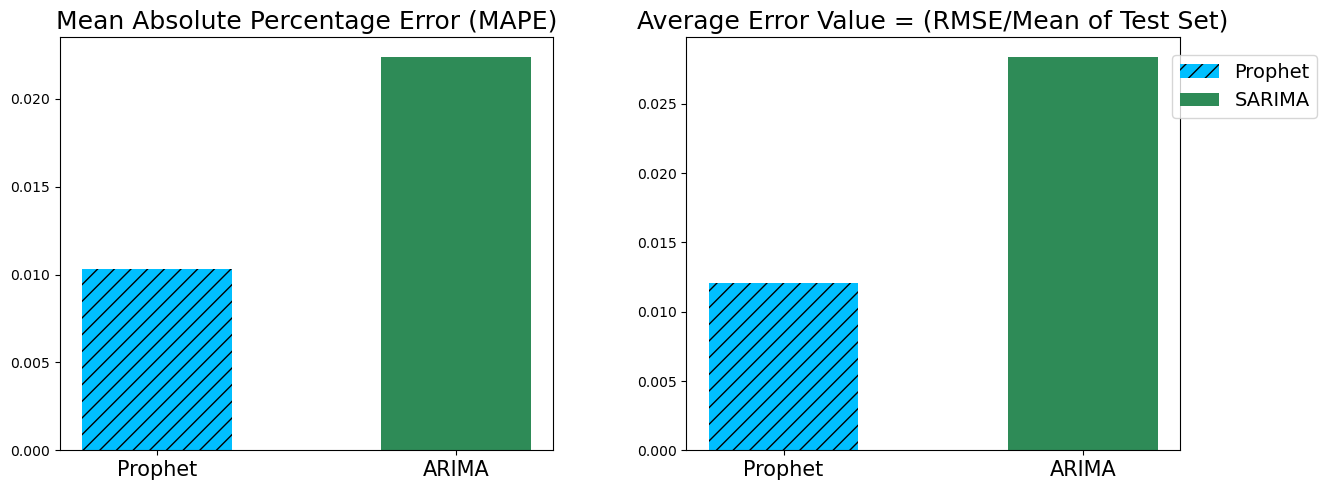

In [64]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.title('Mean Absolute Percentage Error (MAPE)', fontsize=18)
plt.bar(0, prophet_mape_error, 0.5, label='Prophet', hatch='//', color=np.array(('deepskyblue', 'deepskyblue')))
plt.bar(1, sarima_mape_error, 0.5, label='SARIMA', color=np.array(('seagreen', 'seagreen')))
plt.xticks([0, 1], ['Prophet', "ARIMA"], fontsize=15)

plt.subplot(122)
plt.title('Average Error Value = (RMSE/Mean of Test Set)', fontsize=18)
plt.bar(0, prophet_rmse_error.mean()/mean_value, 0.5, hatch='//', color=np.array(('deepskyblue', 'deepskyblue')))
plt.bar(1, sarima_rmse_error/mean_value, 0.5, color=np.array(('seagreen', 'seagreen')))
plt.xticks([0, 1], ['Prophet', "ARIMA"], fontsize=15)


plt.figlegend(loc='upper right', ncol=1, labelspacing=0.5, fontsize=14, bbox_to_anchor=(1.11, 0.9))
plt.tight_layout(w_pad=6)
plt.show()

# Forecasting Till 2027

## SARIMA

In [86]:
from statsmodels.tsa.seasonal import seasonal_decompose 

data = monthly_weekday_exits[(monthly_weekday_exits['Date']>="2020-04-01")]
data = data[['Date', 'avg_exits']].set_index('Date')

In [87]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(data['avg_exits'], start_p=1, start_q=1,
                         test='adf', #augmented Dickey–Fuller test
                         max_p=5, max_q=5, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

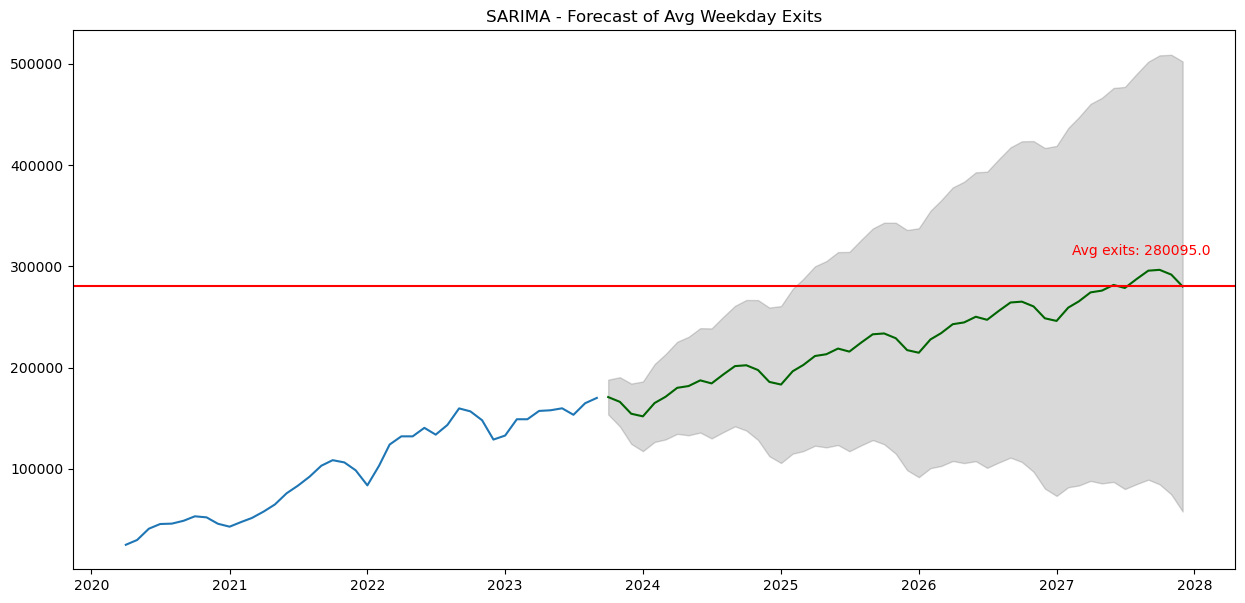

In [89]:
n_periods = 12*4+3
SARIMA_forecast, confint = SARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
SARIMA_forecast = pd.Series(SARIMA_forecast, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)
max_val = fitted_series[len(fitted_series)-1]

    # Plot
plt.figure(figsize=(15,7))
plt.plot(data['avg_exits'], color='#1f76b4')
plt.plot(SARIMA_forecast, color='darkgreen')
plt.fill_between(lower_series.index, 
                lower_series, 
                upper_series, 
                color='k', alpha=.15)

plt.title("SARIMA - Forecast of Avg Weekday Exits")
plt.axhline(max_val, color="red")
text = "Avg exits: " + str(np.round(max_val, 0))
plt.text(2.0, 0.8, text, transform = ax.transAxes, color='red');


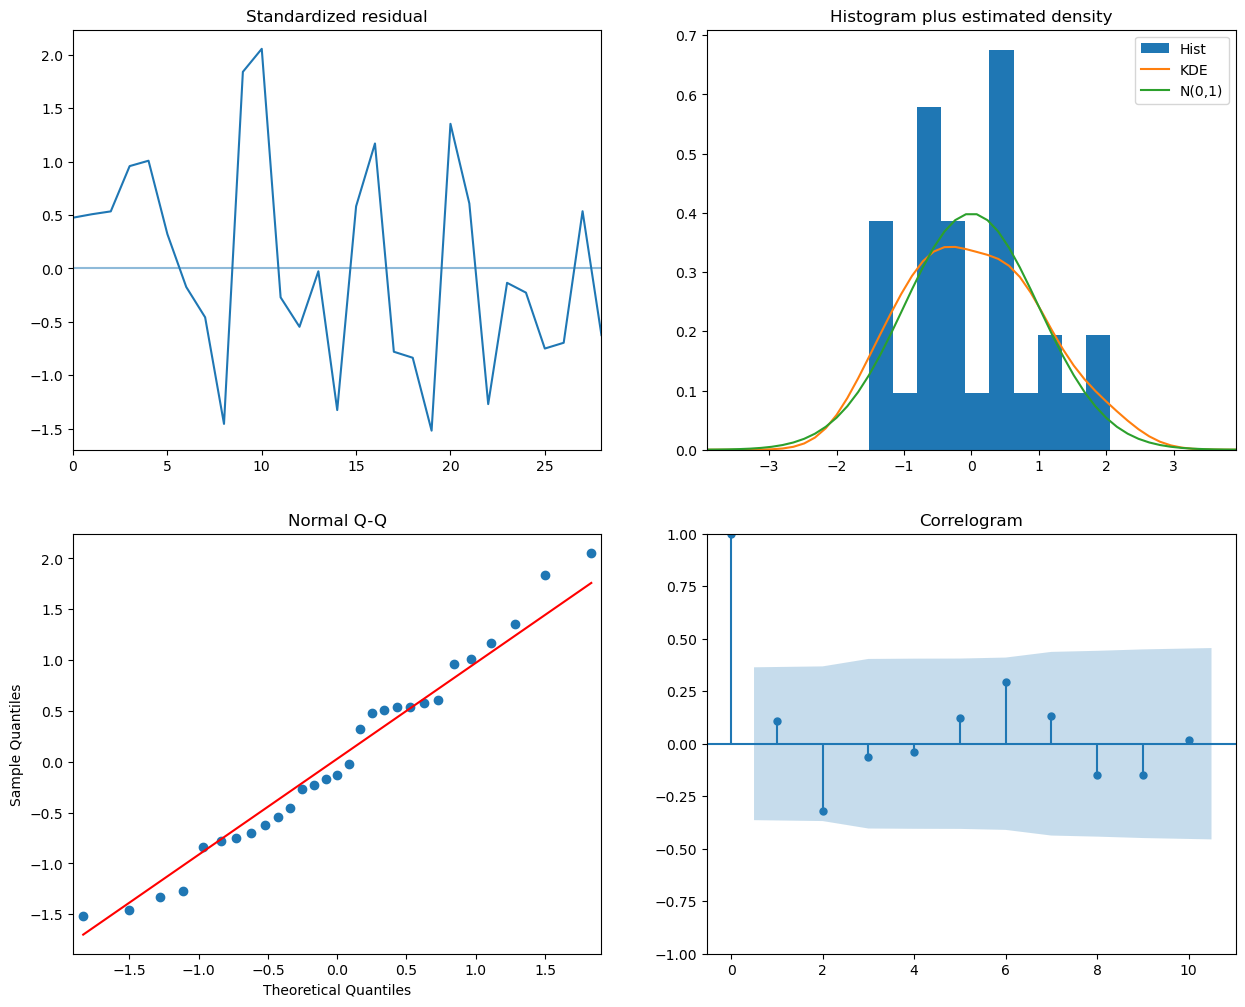

In [81]:
SARIMA_model.plot_diagnostics(figsize=(15,12));

# Prophet 

17:06:44 - cmdstanpy - INFO - Chain [1] start processing
17:06:44 - cmdstanpy - INFO - Chain [1] done processing


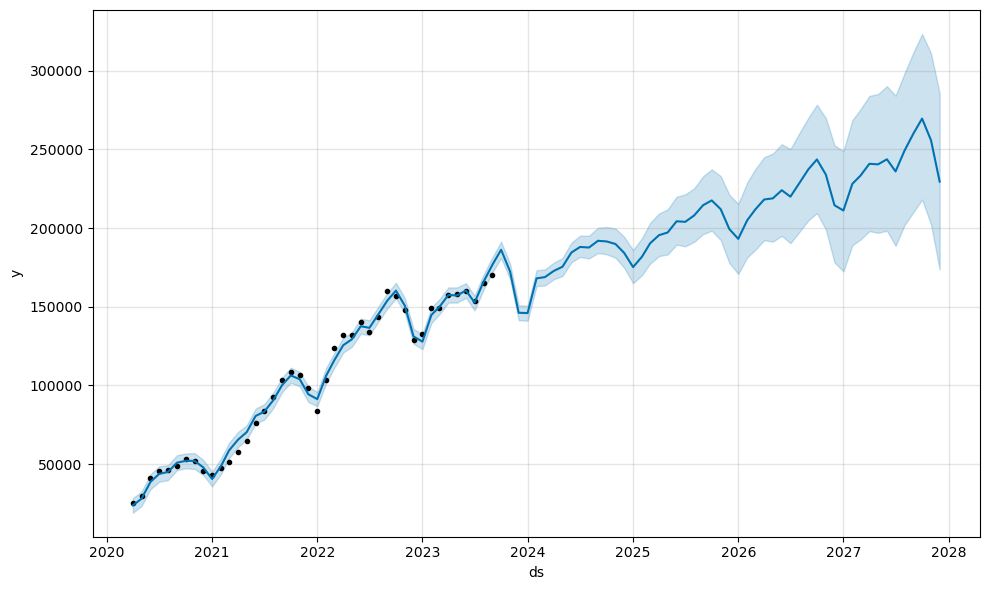

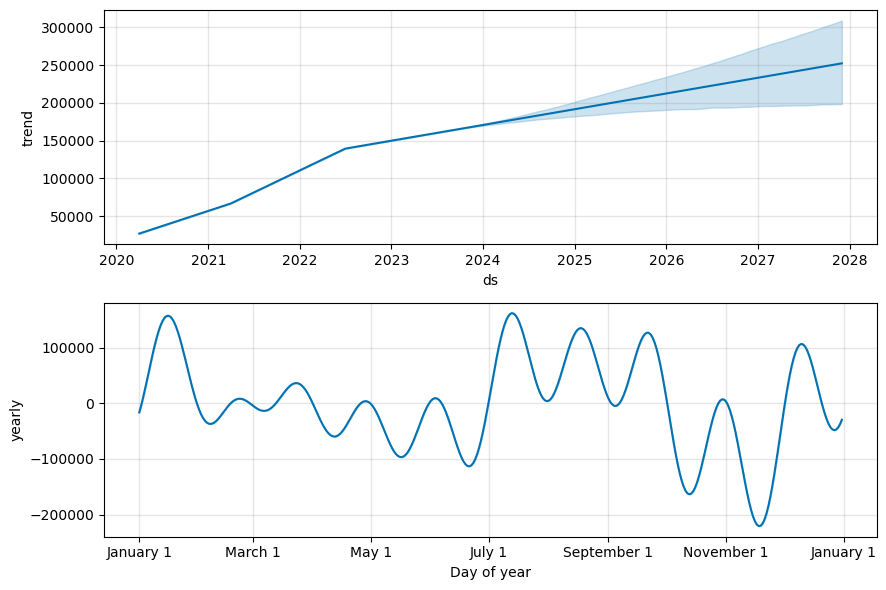

In [69]:
data = monthly_weekday_exits[monthly_weekday_exits["Date"] >= "2020-04-01"][['Date', 'avg_exits']]
data = data.rename(columns={"Date": "ds", "avg_exits": "y"})

data = data.reset_index().drop(columns='index')
m = Prophet() #seasonality_mode='multiplicative'

m.fit(data)

future = m.make_future_dataframe(periods=12*4+3, freq='MS')
future.tail()

prophet_forecast = m.predict(future)
prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = m.plot(prophet_forecast)
fig2 = m.plot_components(prophet_forecast)

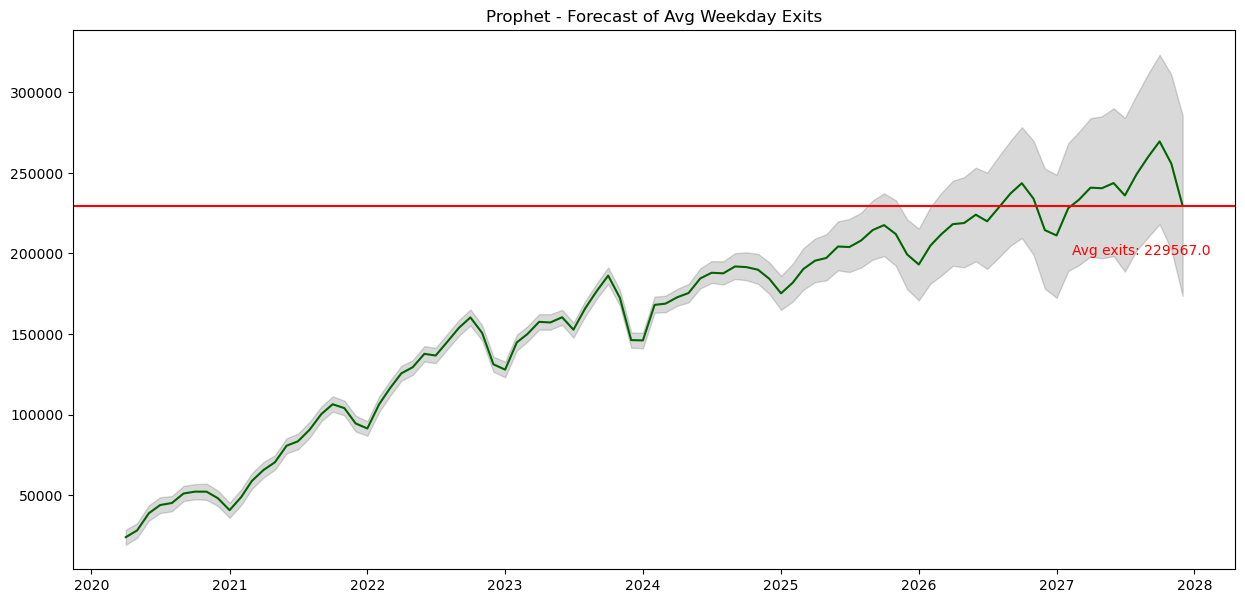

In [70]:
prophet_forecast = prophet_forecast.set_index('ds')

fitted_series = pd.Series(prophet_forecast['yhat'])
lower_series = pd.Series(prophet_forecast['yhat_lower'])
upper_series = pd.Series(prophet_forecast['yhat_upper'])
max_val = fitted_series[len(fitted_series)-1]

    # Plot
plt.figure(figsize=(15,7))
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15);

plt.title("Prophet - Forecast of Avg Weekday Exits")
plt.axhline(max_val, color="red")
text = "Avg exits: " + str(np.round(max_val, 0))
plt.text(2.0, 0.8, text, transform = ax.transAxes, color='red');

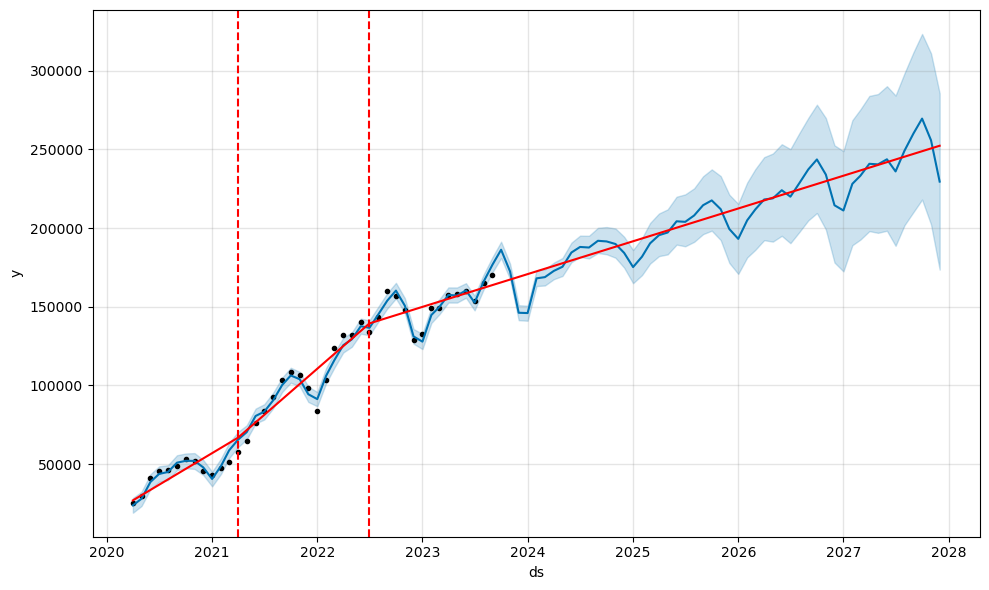

In [76]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(prophet_forecast.reset_index())
a = add_changepoints_to_plot(fig.gca(), m, prophet_forecast.reset_index())

In [91]:
SARIMA_forecast.name = 'Trend'
results = pd.DataFrame(SARIMA_forecast).reset_index()
results['Methodology'] = 'SARIMA'

prf = prophet_forecast.reset_index()[['yhat', 'ds']].rename(columns={'yhat': 'Trend', 'ds': 'index'})
prf = prf[prf['index'] >= '2023-10-01']
prf['Methodology'] = 'PROPHET'

actuals = entries_post2020[['Date', 'avg_exits']].rename(columns={'Date': 'index', 'avg_exits':'Trend'})
actuals['Methodology'] = 'Actuals'

results = results.append(prf).append(actuals)
fig4 = px.line(results, x = "index", y = "Trend", color= 'Methodology',
              labels={"seasonality_relativity": "Seasonality Relativity", "date": "Date", "county": "County"})
fig4.update_layout(title='BART Forecasting Ridership: Prophet vs SARIMAX', xaxis_title='Date', yaxis_title='Avg Weekday Ridership')
fig4.show()

#py.plot(fig4, filename="BART Forecasting Ridership: Prophet vs SARIMAX", auto_open = True);


/var/folders/45/0sm9f9614w77624c01lr1fx40000gn/T/ipykernel_81522/1232359882.py:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/45/0sm9f9614w77624c01lr1fx40000gn/T/ipykernel_81522/1232359882.py:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



# Extra Prophet Manipulation

In [ ]:
date_cond = (monthly_exits["Date"] < "2020-01-01") & (monthly_exits["Date"] >= "2015-01-01")
data2 = monthly_exits[(monthly_exits["Day"] == "weekday") & date_cond]
data2['Month'] = data2['Month'].apply(lambda x: calendar.month_abbr[x])
fig3 = px.line(data2, x = "Month", y = "avg_exits", color = "Year",
              labels={"avg_exits": "Avg BART Exits", "date": "Date", "county": "County"})
fig3.update_layout(
    title={
        'text': "Average Weekday Exits by County (2019-2023)",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig3.show()
#py.plot(fig3, filename="Average Weekday Exits by County (2019-2023)", auto_open = True);

seasonality = avg_exits(data2.groupby(['Month']).mean(numeric_only=True).reset_index())
seasonality['seasonality_relativity'] = np.divide(seasonality['Exits'], seasonality['Exits'].mean())

#seasonality['Month'] = seasonality['Month'].apply(lambda x: calendar.month_abbr[x])

fig4 = px.line(seasonality, x = "Month", y = "seasonality_relativity",
              labels={"seasonality_relativity": "Seasonality Relativity", "date": "Date", "county": "County"})
fig4.add_hline(y=1.0)
fig4.show()


In [ ]:
# cross validation
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

In [ ]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [ ]:
#can add holidays in Prophet
final_model = Prophet()
final_model.add_country_holidays(country_name='US')
forecast = final_model.fit(data).predict(future)
fig = final_model.plot(forecast)